# #Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
import os
import scipy.io
import shutil

C:\Users\prakash270499\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Dataset

In [2]:
# Path to images and annotations
path_images = r"C:\Users\prakash270499\Documents\caltech-101\caltech-101\101_ObjectCategories\airplanes"
path_annot = r"C:\Users\prakash270499\Documents\caltech-101\caltech-101\Annotations\Airplanes_Side_2"
# list of paths to images and annotations
image_paths = [f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))]
annot_paths = [f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size inorder to make it square

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(os.path.join(path_annot, annot_paths[i]))["box_coord"][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.preprocessing.image.load_img(os.path.join(path_images, image_paths[i]),)
    (w, h) = image.size[:2]

    # resize image
    image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.preprocessing.image.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),   
    np.asarray(targets[: int(len(targets) * 0.8)]),
)

(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)


# # MLP

In [3]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# # Patch creation layer

In [4]:
#parent class
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches( 
            images=images, 
            sizes=[1, self.patch_size, self.patch_size, 1], 
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID")
#         tf.image.extract_patches returns A 4-D Tensor with shape [batch, in_rows, in_cols, depth]
        # It returns a tensor containing the extracted patches
    
    
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])  #need to check
#returns a new tf.Tensor that has the same values as tensor in the same order, 
#except with a new shape given by shape

# # Display patches for i/p

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch
number of patches to display in each row and column 7


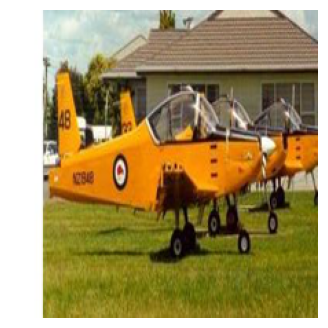

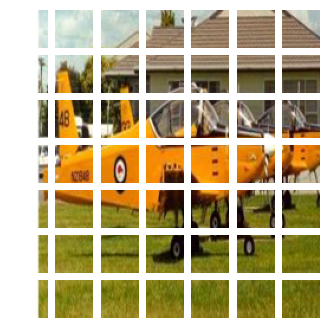

In [5]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
#displays the image from the `x_train` dataset using `imshow` function from Matplotlib
#astype("uint8")converts the image array to unsigned 8-bit integers, for image display
plt.imshow(x_train[3].astype("int32"))
plt.axis("off")


#image is converted to a tensor using `tf.convert_to_tensor`
#call Patches class from above cell
patches = Patches(patch_size)(tf.convert_to_tensor([x_train[3]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# square root of the number of patches to determine the number of patches to display 
n = int(np.sqrt(patches.shape[1]))
print('number of patches to display in each row and column' , n)

plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("int32"))
    plt.axis("off")

# patch encoder layer for nonneg

In [6]:
# Import the constraints module
from tensorflow.keras import constraints

# child class -- inherits from parent class
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches,
            output_dim=projection_dim,
        )
        self.position_embedding_dense = layers.Dense(units=projection_dim, activation="relu")
        self.position_embedding_constraint = constraints.non_neg()  # Add NonNeg constraint
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embedded = self.position_embedding(positions)
        positions_embedded_dense = self.position_embedding_dense(positions_embedded)
        positions_embedded_dense = self.position_embedding_constraint(positions_embedded_dense)
        encoded = self.projection(patch) + positions_embedded_dense
        return encoded


# #build a ViT model

In [7]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        #Small float added to variance to avoid dividing by zero. Defaults to 1e-3
        
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.which performs self attention 
        
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1.
        #they help the network learn more effectively by allowing 
        #it to skip over certain layers that may not be as useful for learning
        
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        #. Layer normalization is used in transformers instead of batch normalization 
        #because it is efficient and can create relevance matrix in one go on all the entity.
        
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    # layer normalization is applied to the `encoded_patches`
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    
    #regularization is applied i.e. avoid overfit
    representation = layers.Dropout(0.3)(representation)
    
    # Add MLP.i.e. from mlp creation:
    # x= inputs, hidden_units=mlp_head_units, dropout_rate=0.3)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

# #Run the experiment

In [8]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    
#AdamW optimizer from the TensorFlow Addons library is created 
#`tfa.optimizers.AdamW` with the specified learning rate & weight decay

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
            #monitors the validation loss and stops training if the loss doesn't improve for a specified number of epochs
        ],
    )

    return history


In [9]:
#Define everything here

input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
#how this formula came ?
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 47s 1s/step - loss: 1.1289 - val_loss: 0.3470
Epoch 2/100
18/18 [==============================] - 14s 799ms/step - loss: 0.3698 - val_loss: 0.3079
Epoch 3/100
18/18 [==============================] - 13s 753ms/step - loss: 0.3126 - val_loss: 0.2705
Epoch 4/100
18/18 [==============================] - 13s 727ms/step - loss: 0.2571 - val_loss: 0.2333
Epoch 5/100
18/18 [==============================] - 14s 786ms/step - loss: 0.2174 - val_loss: 0.1993
Epoch 6/100
18/18 [==============================] - 13s 737ms/step - loss: 0.1888 - val_loss: 0.1682
Epoch 7/100
18/18 [==============================] - 19s 1s/step - loss: 0.1554 - val_loss: 0.1393
Epoch 8/100
18/18 [==============================] - 11s 612ms/step - loss: 0.1273 - val_loss: 0.1131
Epoch 9/100
18/18 [==============================] - 16s 898ms/step - loss: 0.1026 - val_loss: 0.0899
Epoch 10/100
18/18 [==============================] - 14s 753ms/step - loss: 0.0814 - va

# # Evaluate the model

1/1 [==============================] - 0s 41ms/step
mean_iou: 0.8726478109942365


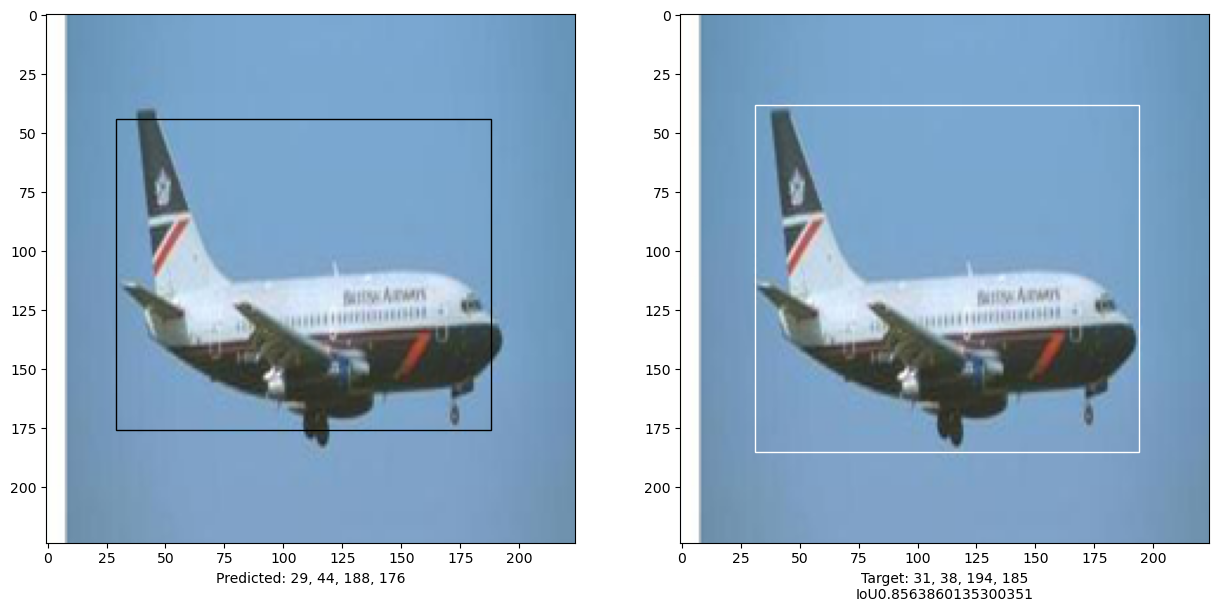

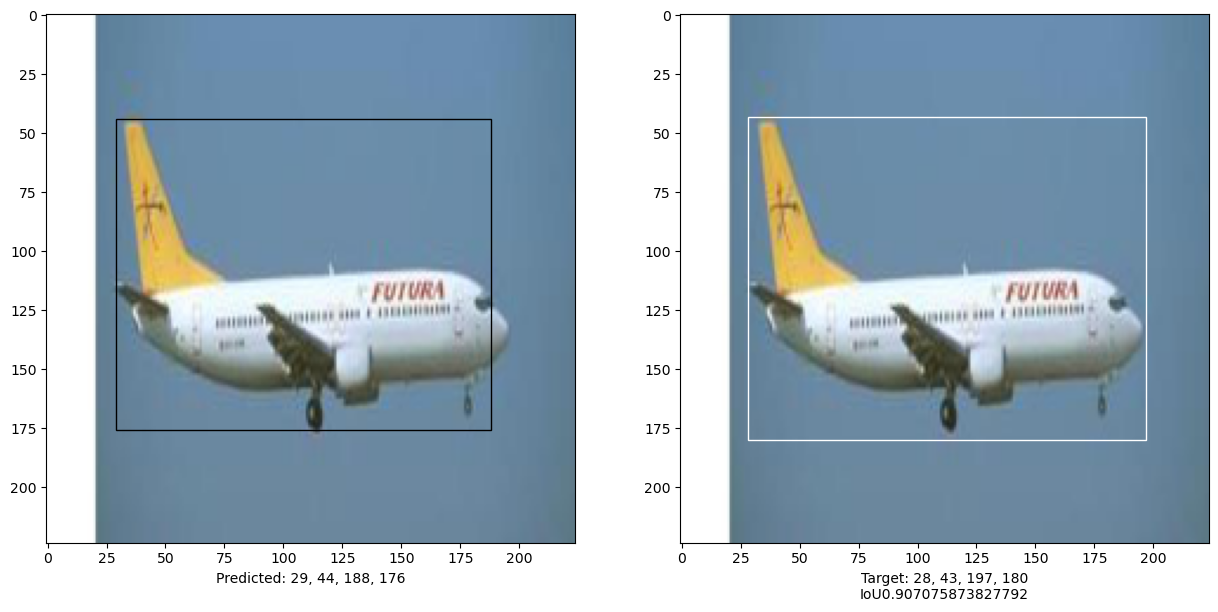

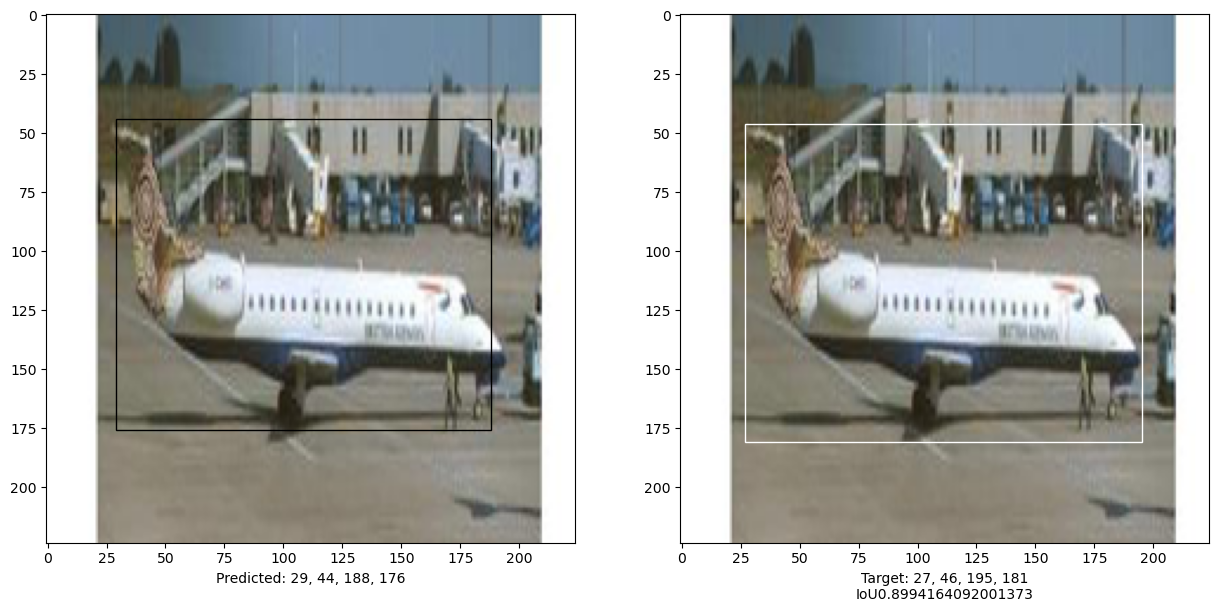

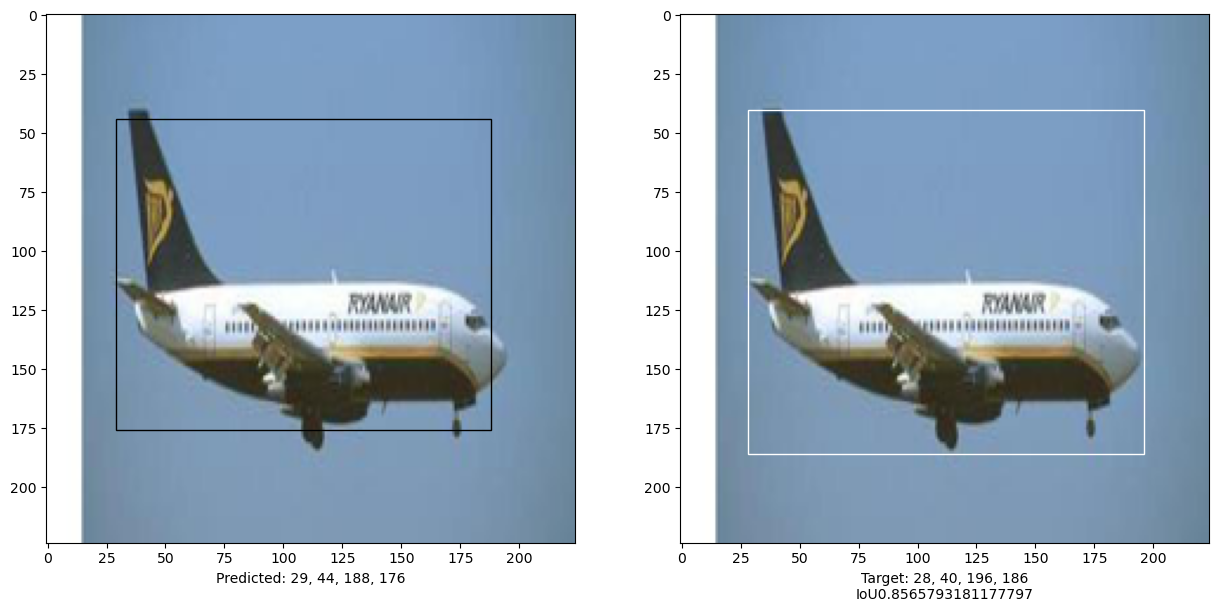

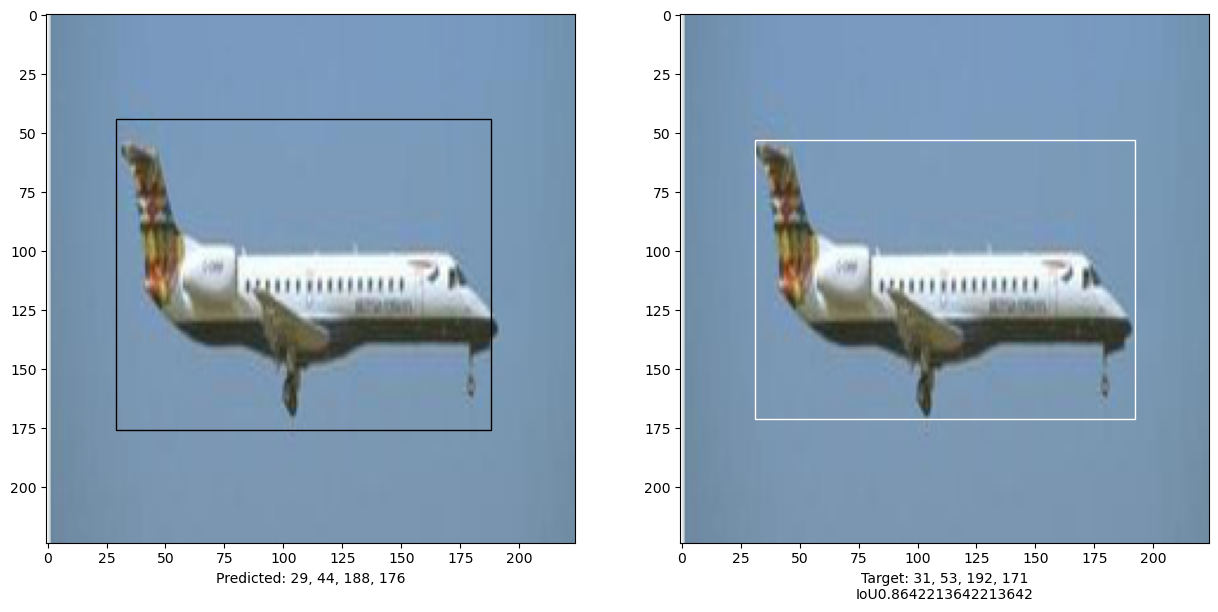

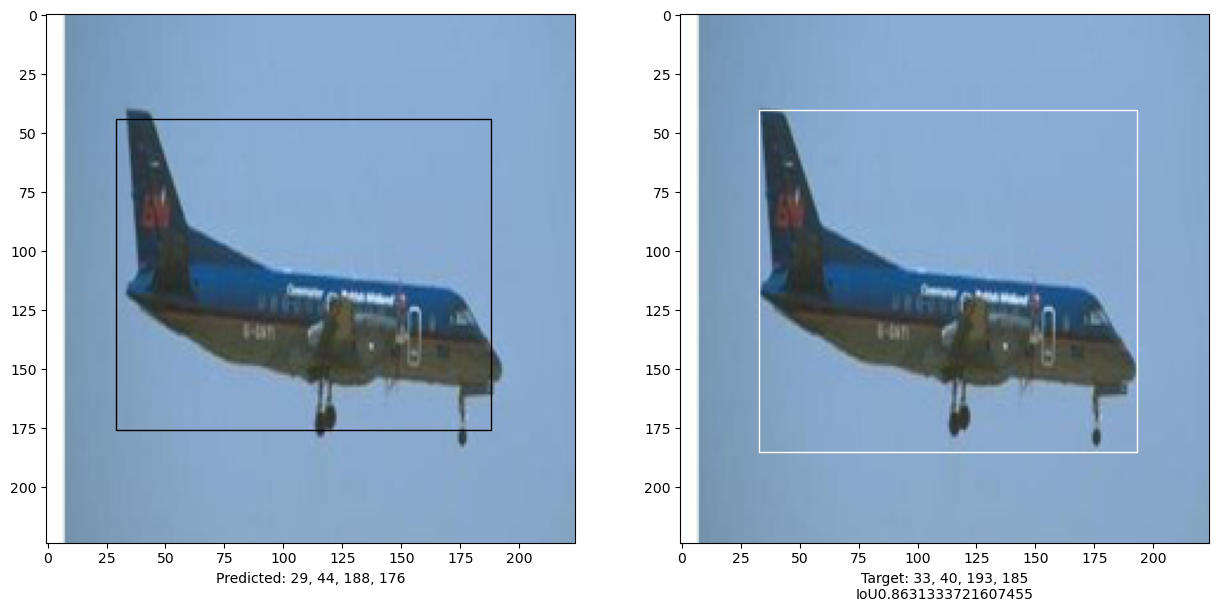

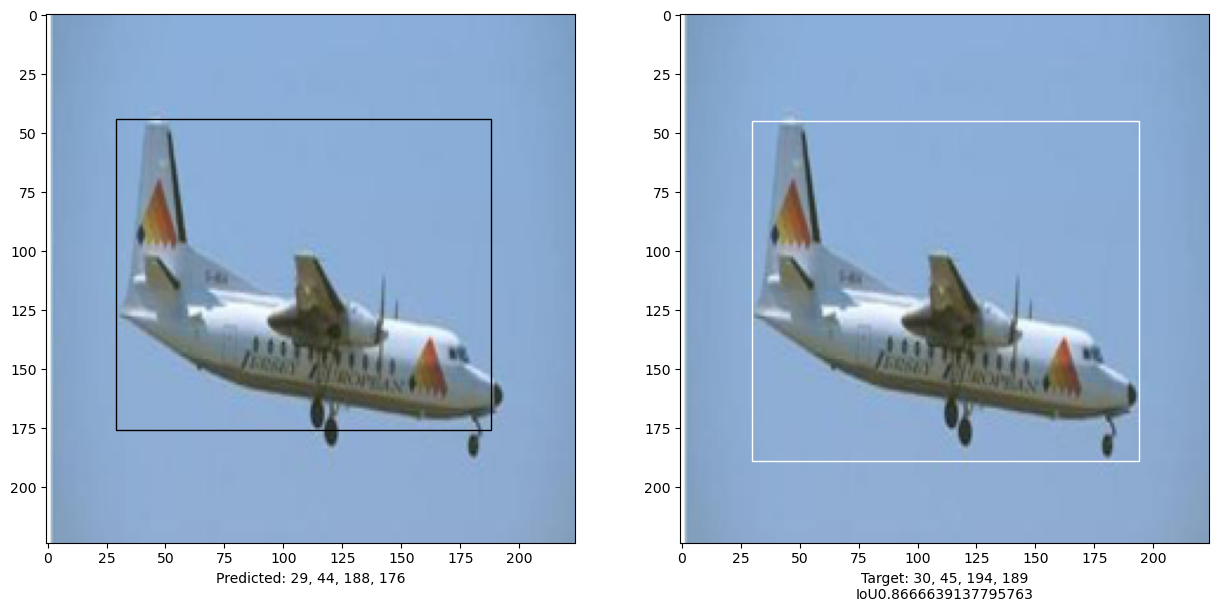

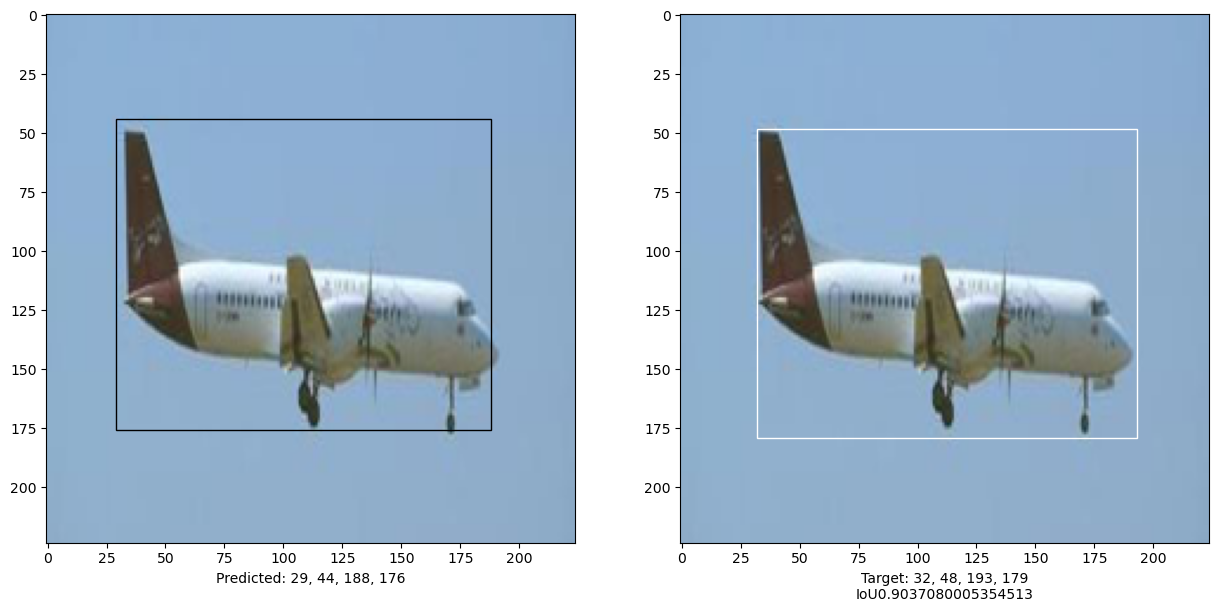

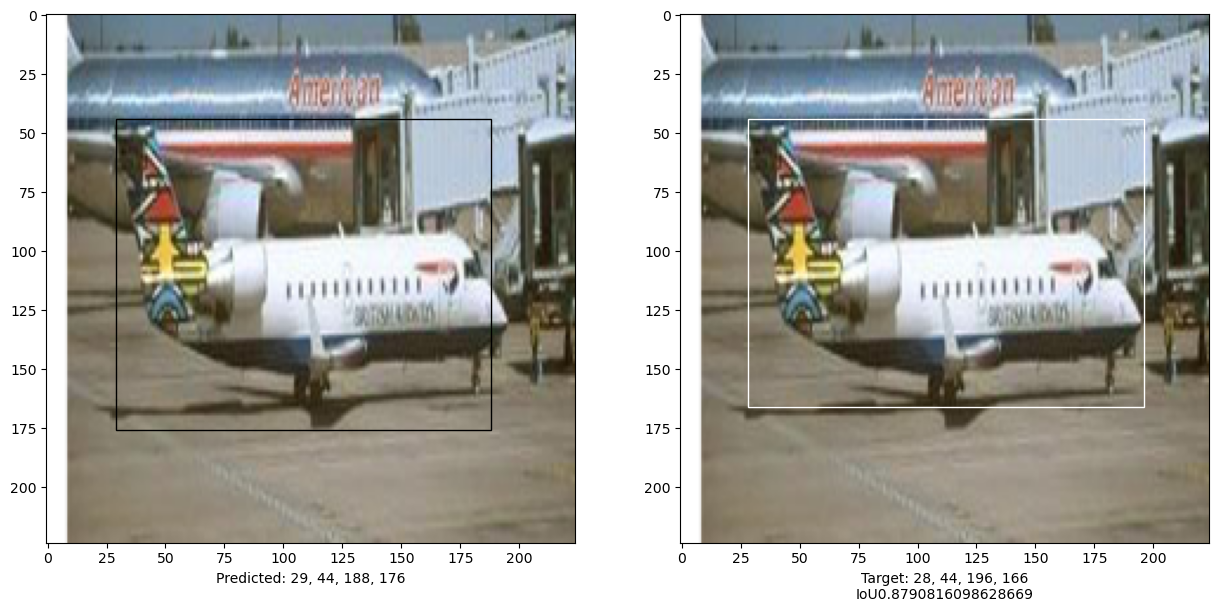

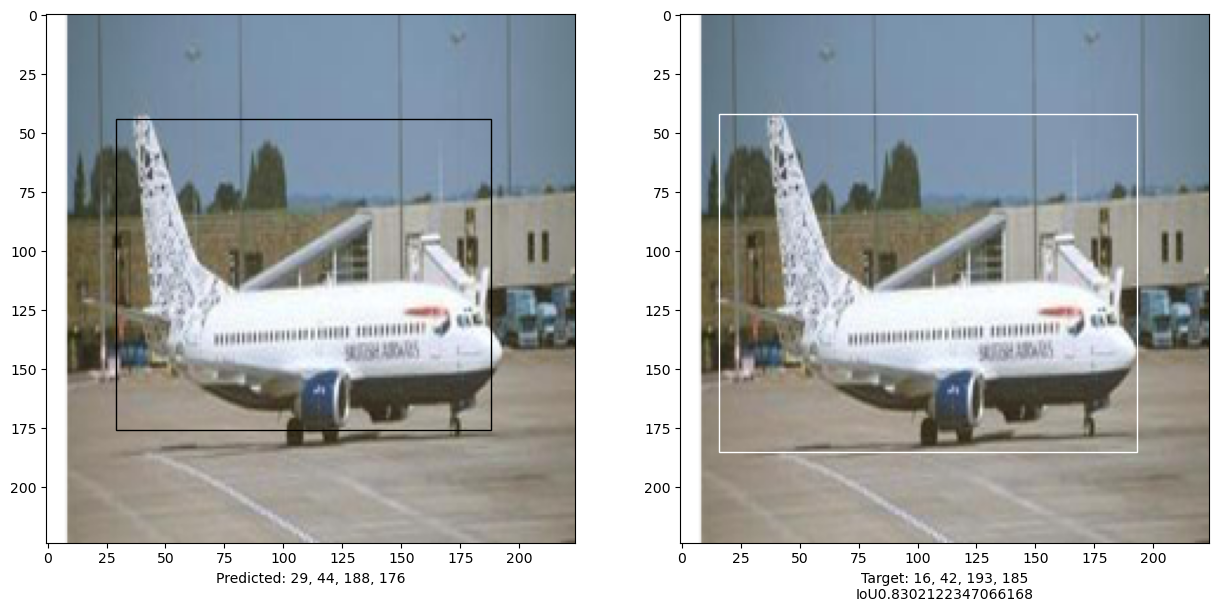

In [10]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# IOU-overlapping between two bounding boxes—a predicted bounding box 
# and a ground truth bounding box.

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("int32"))
    ax2.imshow(im.astype("int32"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]
#formula for rectangle of original bounding box of input image

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box using below formula
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="black",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )
    
#formula for rectangle of original bounding box of predicted image
    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="white",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

In [47]:
#both are same images but the bounding box is different

In [19]:
w = tf.constant([5, -4, 6, 7])
#y = tf.constant([5, 2, 5, 10])
tf.math.greater_equal(w, 0)

#changing negative value into 0 using greater_equal.
#w = tf.constant
#w * tf.cast(tf.greater_equal(w, 0.0), backend.floatx()


<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True, False,  True,  True])>

# SINE 
In the vision transformer, the sine positional encoding is typically applied after the patches are extracted and encoded. Here's an explanation of the steps involved in the sine positional encoding:

Calculate the positional encoding matrix: The positional encoding matrix is computed based on the number of patches and the projection dimension. Each element in the matrix represents a position in the input sequence.

Split the positional encoding matrix into sine and cosine components: The positional encoding matrix is split into two equal halves, one for the sine components and the other for the cosine components. This splitting allows the model to capture different frequencies of positional information.

Scale the positional encoding matrix: The positional encoding matrix is scaled by a factor determined by the projection dimension. This scaling ensures that the positional information has a similar magnitude to the encoded patches.

Add the positional encoding to the encoded patches: The positional encoding matrix is added to the encoded patches, element-wise. This operation combines the learned representations of the patches with the positional information.

The sine positional encoding helps the vision transformer model to understand the relative positions of different patches in the input image. It provides the model with spatial context and allows it to learn spatial dependencies between patches, which is crucial for tasks like object detection or image classification.

By incorporating the sine positional encoding, the vision transformer can effectively leverage the advantages of both self-attention mechanisms and positional information, leading to improved performance on various computer vision tasks.




